In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *
from models.scorenetwork import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
from itertools import chain
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import HTML
from IPython.display import clear_output

/home/oem/anaconda3/envs/xu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_20027/3816732327.py:11: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [2]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

# cuda = True if torch.cuda.is_available() else False
# FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
# torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = './results/MNIST_DAE'
model_dir = './results/checkpoints/DAE_MNIST'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
joint_training = True
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 10
annealed_step = 100

In [4]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../Data/MNIST/',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [5]:
sigma =  5.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

vae = VAE(input_size=image_size, h_dim=h_dim, z_dim=z_dim, type='ce').to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# sn = SN_Model(device, n_steps, sigma_min, sigma_max, dim=z_dim, p = 0.3)
sn = SN_Model(marginal_prob_std=marginal_prob_std_fn, embed_dim=20, dim=z_dim, drop_p=0.3, device=device)
sn_optim = torch.optim.Adam(sn.parameters(), lr = 0.005)
# dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)

joint_optim = torch.optim.Adam(params=chain(vae.parameters(), sn.parameters()))

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        if joint_training:
            mu, log_var = vae.encode(x)
            z = vae.reparameterize(mu, log_var)
            x_reconst = vae.decode(z)
            # Compute reconstruction loss and kl divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss_sn = sn.loss(z)
            loss = loss_sn + reconst_loss + kl_div

            joint_optim.zero_grad()
            loss.backward()
            joint_optim.step()
        else:
            #============= First Stage: Update VAE ==============#
            # Forward pass
            x_reconst, mu, log_var = vae(x)
            # Compute reconstruction loss and kl divergence
            # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
            reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Backprop and optimize
            vae_loss = reconst_loss + kl_div
            vae_optimizer.zero_grad()
            vae_loss.backward()
            vae_optimizer.step()

            #============= Second Stage: Update SN ==============#
            mu, log_var = vae.encode(x)
            z = vae.reparameterize(mu, log_var)

            loss_sn = sn.loss(z)
            vae_optimizer.zero_grad()
            sn_optim.zero_grad()
            loss_sn.backward()
            sn_optim.step()

        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Diffuse loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), loss_sn.item()))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(x.shape[0], z_dim).to(device)
        out = vae.decode(z).view(-1, 1, 28, 28)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = vae(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

        # Save the diffused ima ges
        # dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
        # z_ = forward_proc(z, sigma_min, sigma_max, n_steps, device=device, only_final=True)
        # sample = dynamic.sampling(x.shape[0], z_dim, sample=z_, only_final=True)

        sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=x.shape[0], num_steps=100, device=device)

        # sample = dynamic.sampling(x.shape[0], z_dim, only_final=True)
        out = vae.decode(sample).view(-1, 1, 28, 28)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'diffuse-{}.png'.format(epoch+1)))
torch.save({'sn_state':sn.state_dict(), 'vae_state':vae.state_dict()}, model_dir+'ckpt.pth')


/home/oem/anaconda3/envs/xu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [100/469], Reconst Loss: 21984.9648, KL Div: 1574.7432, Diffuse loss: 1644.3140
Epoch[1/15], Step [200/469], Reconst Loss: 18273.4199, KL Div: 2045.6492, Diffuse loss: 1399.2081
Epoch[1/15], Step [300/469], Reconst Loss: 15365.5625, KL Div: 2263.0479, Diffuse loss: 1538.3171
Epoch[1/15], Step [400/469], Reconst Loss: 13649.6201, KL Div: 2469.4243, Diffuse loss: 1373.6440


/home/oem/Documents/wangxu/LSGM-demo/models/scorenetwork.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Epoch[2/15], Step [100/469], Reconst Loss: 13368.8320, KL Div: 2711.3716, Diffuse loss: 1463.8529
Epoch[2/15], Step [200/469], Reconst Loss: 13172.0488, KL Div: 2899.0996, Diffuse loss: 1387.6638
Epoch[2/15], Step [300/469], Reconst Loss: 12144.9375, KL Div: 2797.7549, Diffuse loss: 1437.9603
Epoch[2/15], Step [400/469], Reconst Loss: 12672.6562, KL Div: 2989.8809, Diffuse loss: 1344.2297
Epoch[3/15], Step [100/469], Reconst Loss: 11511.9160, KL Div: 2997.6885, Diffuse loss: 1386.6429
Epoch[3/15], Step [200/469], Reconst Loss: 11949.3809, KL Div: 3064.1514, Diffuse loss: 1378.7516
Epoch[3/15], Step [300/469], Reconst Loss: 11616.5488, KL Div: 3124.2261, Diffuse loss: 1326.7659
Epoch[3/15], Step [400/469], Reconst Loss: 11256.7090, KL Div: 3045.3567, Diffuse loss: 1301.9614
Epoch[4/15], Step [100/469], Reconst Loss: 11519.0059, KL Div: 3132.7004, Diffuse loss: 1334.7156
Epoch[4/15], Step [200/469], Reconst Loss: 11003.9688, KL Div: 3113.2839, Diffuse loss: 1301.0072
Epoch[4/15], Step [3

In [6]:
def ani_imshow(sample, sampling_number = 64):

    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255

    show_sample = show_sample.astype(np.uint8)

    return show_sample

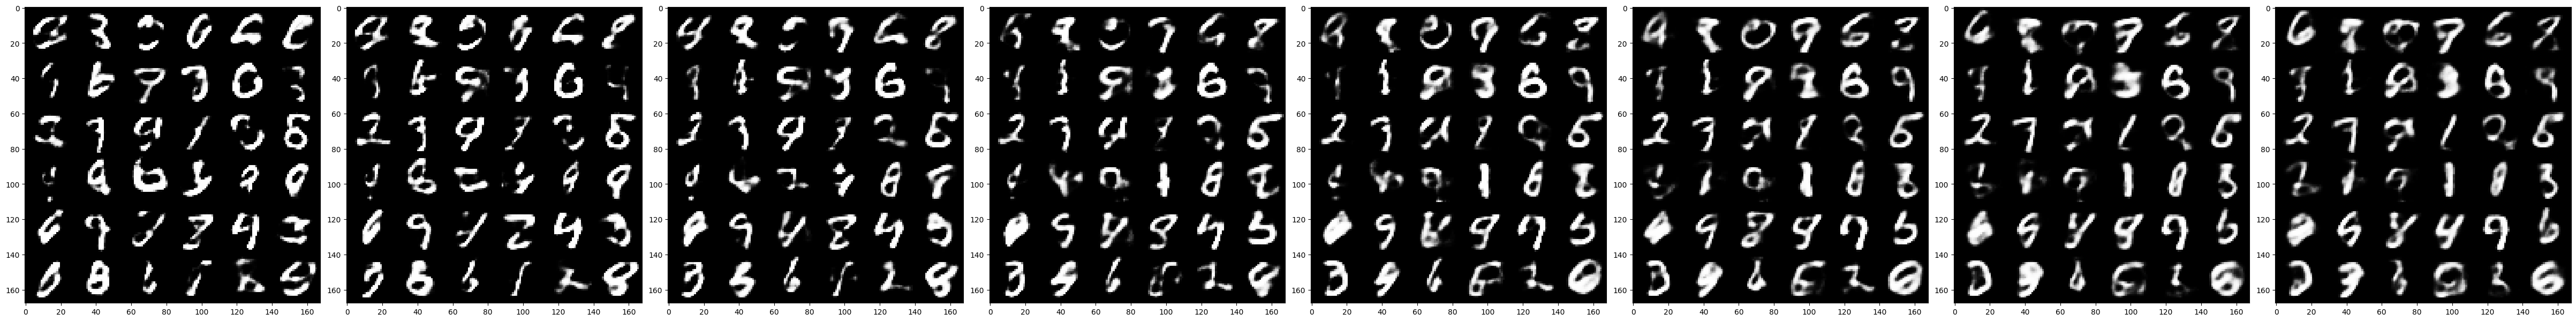

In [7]:
only_final = False
n_steps = 8
test_size = 36
# dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
# sample = dynamic.sampling(test_size, z_dim, only_final=False)
sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=test_size, num_steps=100, device=device, only_final=False)
diffuse_data = vae.decode(sample)

step_size = sample.size(0)
fig, axs = plt.subplots(1, step_size, figsize=(step_size * 6, 6), constrained_layout = True)
for i in range(step_size):
    diff_data = diffuse_data[i].view(-1, 1, 28, 28)
    axs[i].imshow(ani_imshow(diff_data, sampling_number = test_size), animated=True, cmap = 'gray')
    # plt.show()

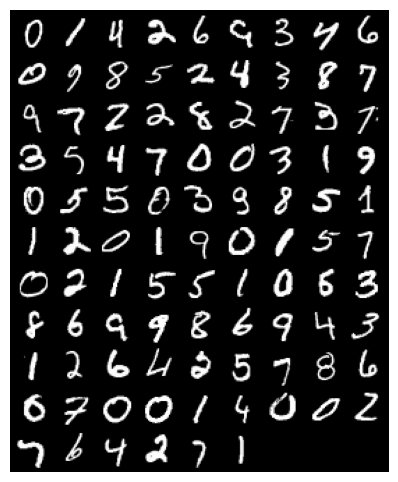

In [8]:
from torchvision.utils import make_grid

sample_grid = make_grid(x.view(-1, 1, 28, 28), nrow=int(np.sqrt(x.shape[0])))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [9]:
z_ = forward_process(z, marginal_prob_std_fn, 100, device=device, end_t=0.2, only_final=True)

In [10]:
sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=z_.shape[0], num_steps=100, device=device, start_t=.2, only_final=True)

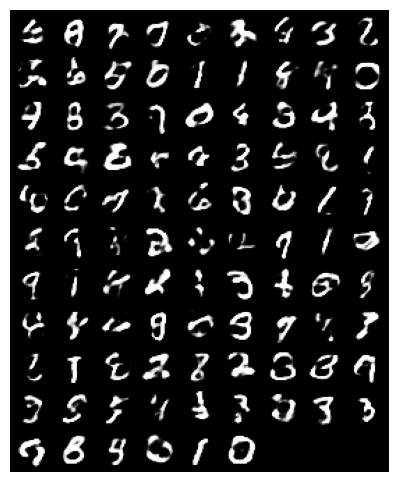

In [11]:
diffuse_data = vae.decode(sample)

from torchvision.utils import make_grid

sample_grid = make_grid(diffuse_data.view(-1, 1, 28, 28), nrow=int(np.sqrt(x.shape[0])))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

### The changes of one sample

In [17]:
recon_x, _, _ = vae(x[0])

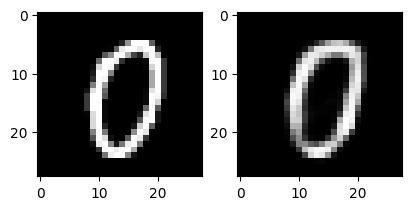

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 2, 2), constrained_layout = True)
axs[0].imshow(ani_imshow(x[0].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[1].imshow(ani_imshow(recon_x.view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')

In [34]:
mu, log_var = vae.encode(x[0])
z = vae.reparameterize(mu, log_var)

z_ = forward_process(z, marginal_prob_std_fn, num_steps=10, device=device, end_t=0.5, only_final=False)
recon_x_seq = vae.decode(z_).clamp(0.0, 1.0)

Text(0.5, 1.0, 'Forward process in latent space and its reconstruction')

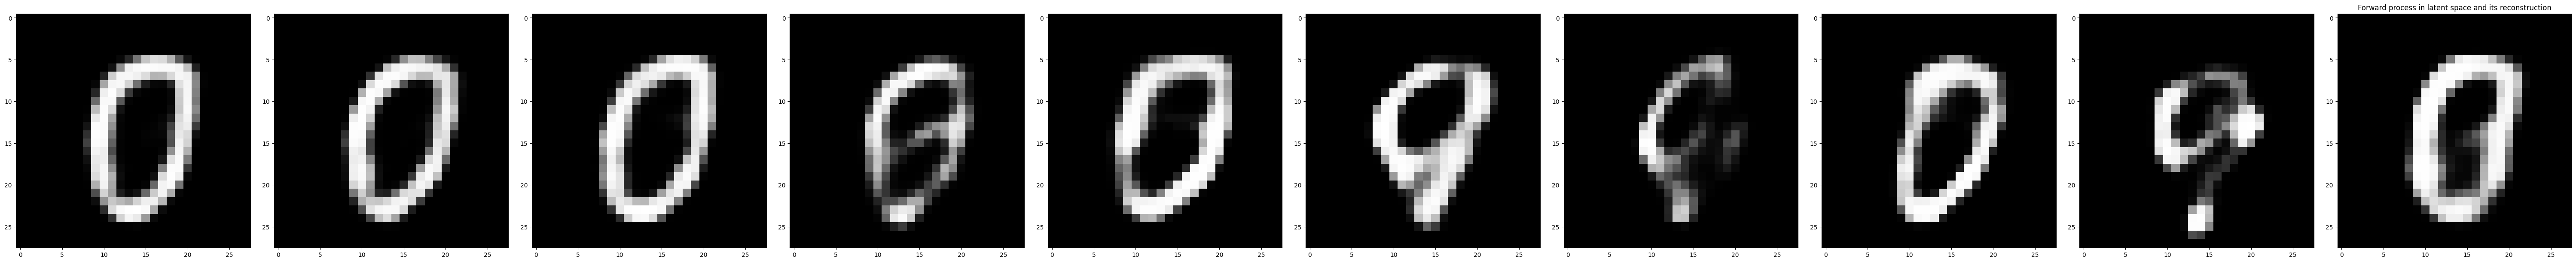

In [51]:
fig, axs = plt.subplots(1, recon_x_seq.shape[0], figsize=(recon_x_seq.shape[0] * 6, 6), constrained_layout = True)
for i in range(recon_x_seq.shape[0]):
    diff_data = recon_x_seq[i].view(-1, 1, 28, 28)
    axs[i].imshow(ani_imshow(diff_data, sampling_number = 1), animated=True, cmap = 'gray')
plt.title('Forward process in latent space and its reconstruction')

In [45]:
sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, dim=z_dim, batch_size=1, num_steps=100, device=device, save_times=10, start_t=.5, only_final=False, init_x=z_[-1])

diffuse_data = vae.decode(sample)

/home/oem/Documents/wangxu/LSGM-demo/models/scorenetwork.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Text(0.5, 1.0, 'Reverse process in latent space and its reconstruction')

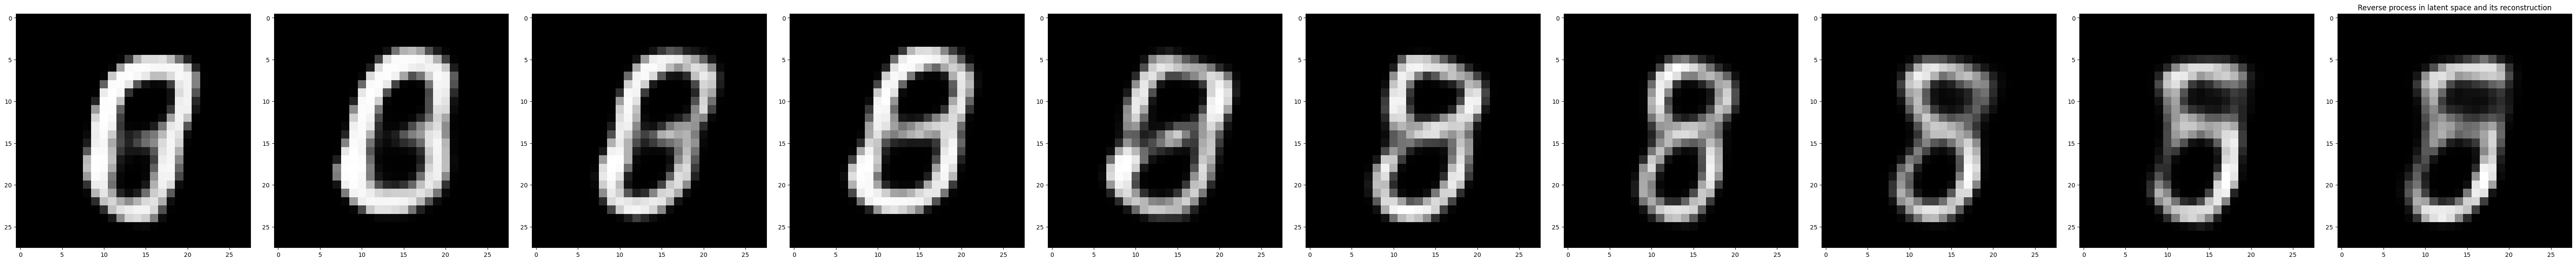

In [52]:
step_size = diffuse_data.shape[0]
fig, axs = plt.subplots(1, step_size, figsize=(step_size * 6, 6), constrained_layout = True)
for i in range(step_size):
    diff_data = diffuse_data[i].view(-1, 1, 28, 28)
    axs[i].imshow(ani_imshow(diff_data, sampling_number = 1), animated=True, cmap = 'gray')
plt.title('Reverse process in latent space and its reconstruction')